In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
import shutil

#from klusta.launch import klusta as klaunch

In [4]:
# session paths
source  = 'Z:\\Andrey\\data'
#animal  = '006865'
#session = '006865_hippoSIT_2021-12-17_15-14-51'
animal  = 'GB0090'
session = 'GB0090_openfield_2021-09-30_12-09-27'

session_path = os.path.join(source, animal, session)

## Copy Neurosuite settings files

In [5]:
settings_source = os.path.join(source, animal)
ns_settings_file = os.path.join(settings_source, 'default.xml')
kwik_params_file = os.path.join(settings_source, 'default.prm')
kwik_probes_file = os.path.join(settings_source, 'default.prb')

shutil.copy(ns_settings_file, os.path.join(session_path, '%s.xml' % session))
shutil.copy(kwik_params_file, os.path.join(session_path, '%s.prm' % session))
shutil.copy(kwik_probes_file, os.path.join(session_path, '%s.prb' % session))

with open(os.path.join(session_path, '%s.prm' % session), 'r+') as f:
    content = f.read()
    f.seek(0, 0)
    lines = "experiment_name = '%s'\nprb_file = '%s.prb'\n \n" % (session, session)
    f.write(lines.rstrip('\r\n') + '\n' + content)

## Conversion of MCS .h5 to .dat file

http://neurosuite.sourceforge.net/formats.html


In [7]:
crossref = None
#crossref = 11

#MCS_h5_name = [x for x in os.listdir(session_path) if x.startswith('Andrey') and x.endswith('.h5')][0]
MCS_h5_name = [x for x in os.listdir(session_path) if x.startswith(animal) and x.endswith('.h5')][0]
chunk_size = 25000 # 1 second at sampling rate 25kHz
dest_file = os.path.join(session_path, '%s.dat' % session)
if crossref is not None:
    dest_file = os.path.join(session_path, '%s.cf.dat' % session)
if not os.path.exists(session_path):
    os.makedirs(session_path)
if os.path.exists(dest_file):
    os.remove(dest_file)

with h5py.File(os.path.join(session_path, MCS_h5_name), 'r') as f:
    ds = f['Data']['Recording_0']['AnalogStream']['Stream_1']['ChannelData']
    #ds = f['Data']['Recording_0']['AnalogStream']['Stream_2']['ChannelData']
    print("Channels: %s, samples: %s, type: %s" % (ds.shape[0], ds.shape[1], ds.dtype))
    
    chunks_no = int(np.ceil(ds.shape[1]/chunk_size))
    #chunks_no = 60
    for i in range(chunks_no):
        idx = i * chunk_size
        testds = ds[:, idx:idx + chunk_size]
        data = np.array(ds[:, idx:idx + chunk_size]).astype(np.int16)  # int16 is correct
        if crossref is not None:
            to_sub = np.array(data[crossref])
            data -= to_sub
        with open(dest_file, 'ab') as f:
            data.T.flatten().tofile(f)
            
        print("%s percent complete\r" % str(round(100*(i + 1)/float(chunks_no))), end='')

Channels: 32, samples: 12004620, type: int32


## Run spikesorting with Klusta

https://klusta.readthedocs.io/en/latest/sorting/

In [ ]:
prm_file = os.path.join(session_path, '%s.prm' % session)

os.chdir(session_path)
klaunch(prm_file, output_dir=session_path, overwrite=True, legacy_output=True)

## extract data for klusters - .spk, .res, .clu (kwik legacy output does not fit)

In [60]:
# move kwik files to shank folders (required for matlab script)
shank = 1
if not os.path.exists(os.path.join(session_path, str(shank))):
    os.makedirs(os.path.join(session_path, str(shank)))
shutil.copy(os.path.join(session_path, '%s.kwik' % session), os.path.join(session_path, '1', '%s_sh%s.kwik' % (session, shank)))
shutil.copy(os.path.join(session_path, '%s.kwx' % session), os.path.join(session_path, '1', '%s_sh%s.kwx' % (session, shank)))

'Z:\\Andrey\\data\\006865\\006865_hippoSIT_2021-11-08_16-05-00\\1\\006865_hippoSIT_2021-11-08_16-05-00_sh1.kwx'

In [6]:
import matlab
eng = matlab.engine.start_matlab()
eng.addpath(eng.genpath('D:\code\buzcode'))
eng.ConvertKlusta2Neurosuite(1, ss_path, filebase, 1)  # TODO do for each shank
eng.quit()

AttributeError: module 'matlab' has no attribute 'engine'

## extract data for klusters - .fet files

In [76]:
# export features from .kwx and .res to .fet
with h5py.File(os.path.join(session_path, '%s.kwx' % session), 'r') as f:
    groups = list(f['channel_groups'])

for group in groups:
    with h5py.File(os.path.join(session_path, '%s.kwx' % session), 'r') as f:
        feature_vectors = np.array(f['channel_groups'][group]['features_masks'])[:, :, 0]  # take only features
    
    with h5py.File(os.path.join(session_path, '%s.kwik' % session), 'r') as f:
        spike_times = np.array(f['channel_groups'][group]['spikes']['time_samples'])
        clu_count = len([g for g in f['channel_groups'][group]['clusters']['main']])
        
    fet = np.column_stack( [feature_vectors, spike_times] )
    
    fet_file = os.path.join(session_path, '%s.%s.fet' % (session, group))
    np.savetxt(fet_file, fet, header=str(clu_count), comments='', fmt='%d', newline='\n')

In [77]:
# rename files to 'filebase.extention.group'
groups = [x.split('.')[1] for x in os.listdir(session_path) if x.startswith(session) and x.endswith('clu')]

for ext in ('spk', 'res', 'fet', 'clu'):
    for group in groups:
        name_from = os.path.join(session_path, '%s.%d.%s' % (session, int(group), ext))
        name_to   = os.path.join(session_path, '%s.%s.%d' % (session, ext, int(group) + 1))
        os.replace(name_from, name_to)

## Plot waveforms for a spike

In [48]:
session_path = 'D:\\sandbox'
session = '006865_hippoSIT_2021-12-14_16-25-01'

group = 2
channels_no = 15
samples_no  = 32

path_from = os.path.join(session_path, '%s.spk.%s' % (session, group))
wf = np.fromfile(path_from, dtype=np.int16)

spikes_no   = int(wf.shape[0]/(channels_no*samples_no))
wf3 = wf.reshape([spikes_no, samples_no, channels_no])

In [49]:
wf3.shape

(47051, 32, 15)

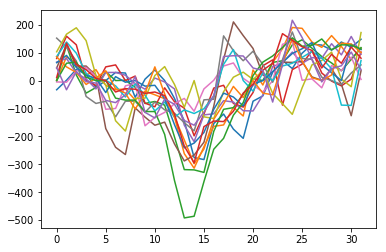

In [74]:
spike = 22770
_ = plt.plot(wf3[spike])

### Sandbox

In [56]:
fpath = 'Z:\\Michael\\FreeBehaving\\SIT_sessions\\52_aSIT_2021-11-17_12-36-47\\52_aSIT_2021-11-17_12-36-47.h5'
with h5py.File(fpath, 'r') as f:
    ds = f['processed']['sound_idxs']
    ds = np.array(ds)

In [69]:
fpath = 'Z:\\Michael\\FreeBehaving\\SIT_sessions\\51_aSIT_2021-11-16_13-33-07\\events.csv'

data = np.loadtxt(fpath, delimiter=',', skiprows=1)

In [72]:
np.any(np.isnan(data))

False